# Introduction
This notebook details the project solution for detecting vehicles.
The steps taken are what was described in the lessons:
 * Extract Features of images, using color/histogram as well as HOG gradients
 * Perform classification by splitting labeled data in train/test sets
 * Use classifier as well as  Hog sub-sampling to locate vehicles in images
 * Deal with false-positives and duplicates using heatmaps
 * Build tracking pipeline to deal with videos

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

## Test boxes around vehicles

In [2]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    # return the image copy with boxes drawn
    for bbox in bboxes:
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    return draw_img # Change this line to return image copy with boxes

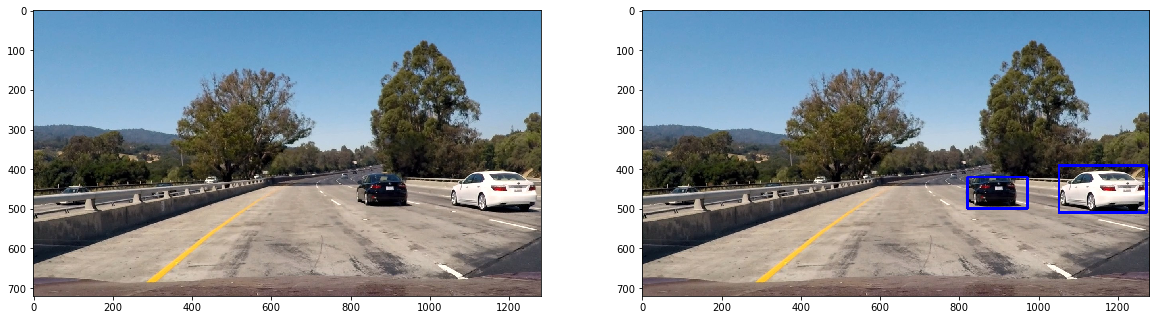

In [13]:
image = mpimg.imread('test_images/test1.jpg')
# Add bounding boxes
bboxes = [((820, 420), (970, 500)), ((1050, 390), (1270, 510))]
result = draw_boxes(image, bboxes)
_, (ax1, ax2) = plt.subplots(1,2, figsize=(20,20))
ax1.imshow(image)
ax2.imshow(result)
plt.show()

## Feature Extraction: Histogram and Spatial Binning of Color
Helper functions that calculate histograms as well as do spatial binning of color. These functions are taken
as provided in the lessons.

In [168]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels 
    rhist =  np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist =  np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist =  np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector  
    return hist_features,rhist, ghist, bhist, bin_centers

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))


## Data Exploration

In [15]:
def data_stats(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = mpimg.imread(car_list[0]).shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = mpimg.imread(car_list[0]).dtype
    # Return data_dict
    return data_dict

('The dataset consists of: ', 8792, ' cars and', 8968, ' non-cars')
('of size: ', (64, 64, 3), ' and data type:', dtype('float32'))


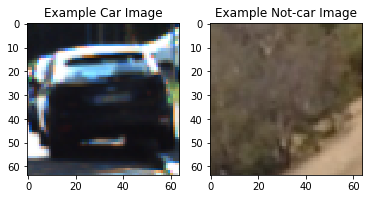

In [19]:
images = glob.glob('./*vehicles/*/*.png')
cars = []
notcars = []

for image in images:   
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)

data_info = data_stats(cars, notcars)

print('The dataset consists of: ', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
plt.show()

## Feature Extraction: HOG Features
Extract HOG features from images. Used code provided in lessons

In [143]:
from skimage.feature import hog
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


## Extract features from images
Use different features for each image to form the basis of features for the classifier

In [145]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [98]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    #print(img.shape)
    if x_start_stop[0] is None:
        x_start_stop[0]=0
    if x_start_stop[1] is None:
        x_start_stop[1]=img.shape[1]
    if y_start_stop[0] is None:
        y_start_stop[0] = 0
    if y_start_stop[1] is None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    # Compute the number of pixels per step in x/y
    # Compute the number of windows in x/y
    # Initialize a list to append window positions to
   
    window_list = []
    
    # Loop through finding x and y window positions
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, 
    # Calculate each window position
    # Append window position to list
        
    for x in range(x_start_stop[0], x_start_stop[1], int((1.0-xy_overlap[0])*xy_window[0])):
        for y in range(y_start_stop[0], y_start_stop[1], int((1.0-xy_overlap[1])*xy_window[1])):
            #print((x,y),(x+xy_window[0],y+xy_window[1]))
            window_list.append(((x,y),(x+xy_window[0],y+xy_window[1])))
        
    # Return the list of windows
    return window_list



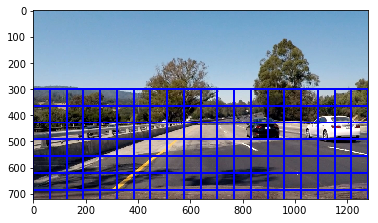

In [99]:
image = mpimg.imread('test_images/test4.jpg')
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[300, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
plt.show()

## Create classifier
Use SVC and Random Forests to classify using the input images provided. 
The code was used as provided in the lessons. 

In [169]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import time

colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)
hist_feat = False
spatial_feat = True

t=time.time()
car_features = extract_features(cars, color_space=colorspace, spatial_size = spatial_size,orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_feat=spatial_feat,hist_feat=hist_feat,
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, color_space=colorspace, spatial_size = spatial_size, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_feat=spatial_feat,hist_feat=hist_feat,
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
clf = RandomForestClassifier(n_estimators=100, random_state=0)
# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train RF...')
# Check the score of the SVC
print('Test Accuracy of RF = ', round(clf.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My RF predicts: ', clf.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with RF')

(73.16, 'Seconds to extract HOG features...')
('Using:', 9, 'orientations', 8, 'pixels per cell and', 2, 'cells per block')
('Feature vector length:', 6060)
(136.46, 'Seconds to train RF...')
('Test Accuracy of RF = ', 0.9868)
('My RF predicts: ', array([ 0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]))
('For these', 10, 'labels: ', array([ 0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]))
(0.00693, 'Seconds to predict', 10, 'labels with RF')


In [170]:
svc = LinearSVC(C=0.1)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')



(14.94, 'Seconds to train SVC...')
('Test Accuracy of SVC = ', 0.9845)
('My SVC predicts: ', array([ 0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]))
('For these', 10, 'labels: ', array([ 0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]))
(0.00115, 'Seconds to predict', 10, 'labels with SVC')


## Sliding windows implementation
Using the classifier we built, we use slidiing windows to search an image for a vehicle. 
Whenever the prediction is 1, we save that window. The code is used as provided by the lessons, with minor modifictions. 

In [188]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    img = img.astype(np.float32)/255
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

## Test the classifier and sliding windows

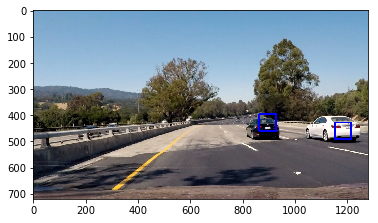

In [189]:
image = mpimg.imread('test_images/test4.jpg')
draw_image = np.copy(image)
y_start_stop = [300, None] # Min and max in y to search in slide_window()
hist_feat = False
hog_feat = True # HOG features on or off
spatial_feat = True
spatial_size = (16, 16)
color_space="YUV"
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, clf, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)
plt.show()


## HOG Subsampling window search
We implement the HOG sub-sampling window search to make the sliding window method more efficient. 
We used the code from the lessons with minor modifications; to handle different color schemes. 

In [166]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)



def find_cars(img, color_space, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    #ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
    
    ctrans_tosearch = feature_image[ystart:ystop,:,:]
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    boxes=[]
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))  
            test_features = X_scaler.transform(np.hstack((spatial_features, hog_features)).reshape(1, -1)) 
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return draw_img, boxes
    

## Testing HOG Subsampling

(6060,)


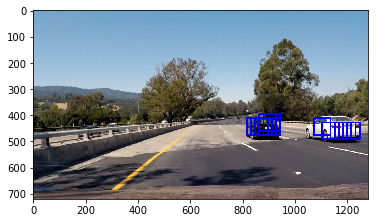

In [171]:
img = mpimg.imread('test_images/test4.jpg')
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
hog_channel = 'ALL'
ystart = 300
ystop =  700
scale = 1.0
    
print X_train[0].shape
out_img, box_list = find_cars(img, color_space, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
plt.imshow(out_img)
plt.show()

## Deal with duplicates and false positives
We use heatmaps to deal with duplicates and false positives. The code below was primarily provided by the lessons, with the method of extending heatmap was suggested in forums to better track images in video.

In [172]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1.0

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def extend_heatmap(labels, heatmap):
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        if nonzero is None:
            continue
    
        heatmap[nonzero] = np.max(heatmap[nonzero])
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        heatmap[np.min(nonzerox):np.max(nonzerox), np.min(nonzeroy):np.max(nonzeroy)] = np.max(heatmap[nonzero])
        
    return heatmap

## Draw boxes  around heatmaps with max value
We use the code provided, also start developing tracking pipeline

In [173]:
class Bbox:
    cord = None
    last_seen = 0
    first_seen = 0
    idx = -1
    last_cords = []

class Bboxes:
    frame_count = 0
    bbox_list = []
    curr_cord_list = []
    next_idx = 0
    
    def __init__(self):
        frame_count = 0
        bbox_list = []
        curr_cord_list = []
        next_idx = 0
        

def draw_labeled_bboxes(img, labels, heatmap, threshold):
    global bboxes
    
    bboxes.curr_cord_list = []
 
    # Iterate through all detected cars
    for car in range(1, labels[1]+1):
        #print("car_number=", car)
        # Find pixels with each car label value
        nonzero = (labels[0] == car).nonzero()
        if nonzero is None:
            continue
            
        heatmap[nonzero] = np.max(heatmap[nonzero])
        if np.max(heatmap[nonzero]) <= threshold:
            continue
        
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        cord = [[np.min(nonzerox), np.min(nonzeroy)], [np.max(nonzerox), np.max(nonzeroy)]]
        bboxes.curr_cord_list.append(cord)
       
        create = True
        
        for prev_box in bboxes.bbox_list:
            if (np.abs(prev_box.cord[0][0]-cord[0][0])) < 20 and\
               (np.abs(prev_box.cord[0][1]-cord[0][1])) < 20 and\
               (np.abs(prev_box.cord[1][0]-cord[1][0])) < 20 and\
               (np.abs(prev_box.cord[1][1]-cord[1][1])) < 20:
                        
                #print("Seeing bbox{}:{} with cords{} again".format(prev_box.idx, prev_box.last_cords, cord))
                prev_box.cord[0][0] = int(0.7*np.average(prev_box.last_cords[:][0][0])  + 0.3*cord[0][0])
                prev_box.cord[0][1] = int(0.7*np.average(prev_box.last_cords[:][0][1])  + 0.3*cord[0][1])
                prev_box.cord[1][0] = int(0.7*np.average(prev_box.last_cords[:][1][0])  + 0.3*cord[1][0])
                prev_box.cord[1][1] = int(0.7*np.average(prev_box.last_cords[:][1][1])  + 0.3*cord[1][1])

                prev_box.last_cords = prev_box.last_cords[-9:] + cord
                prev_box.last_seen = bboxes.frame_count
                    
                create = False
                break
            
        if create == True:
            bbox = Bbox()
            bbox.idx = bboxes.next_idx
            bbox.first_seen = bboxes.frame_count
            bbox.cord = cord
            
            bbox.last_cords = bbox.last_cords[-9:] + cord
            bbox.last_seen = bboxes.frame_count
            
            bboxes.next_idx += 1
            bboxes.bbox_list.append(bbox)
            
            #print("Adding new bbox{} with cord{}".format(bbox.idx, cord))
             
        # Draw the box on the image
        #cv2.rectangle(img, (cord[0][0],cord[0][1]), (cord[1][0], cord[1][1]), (0,0,255), 6)
    
    for bbox in bboxes.bbox_list:
        if bbox.last_seen == bboxes.frame_count:
            #print("box{} seen this frame".format(bbox.idx))
            if bboxes.frame_count > 5 and  (bboxes.frame_count-bbox.first_seen) < 5:
                #print("was first seen in frame{} , ignoring".format(bbox.first_seen))
                continue
            cord = bbox.cord
            cv2.rectangle(img, (cord[0][0],cord[0][1]), (cord[1][0], cord[1][1]), (0,0,255), 6)
       # else:
            #print("box{} seen this frame".format(bbox.idx))
            
    bboxes.frame_count += 1
        #Return the image
    return img

## Test heatmap
Check to see if decrease in false positives/duplicate boxes

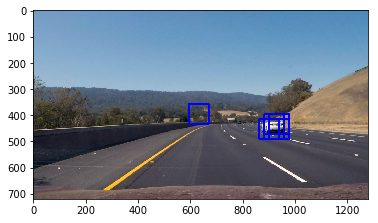

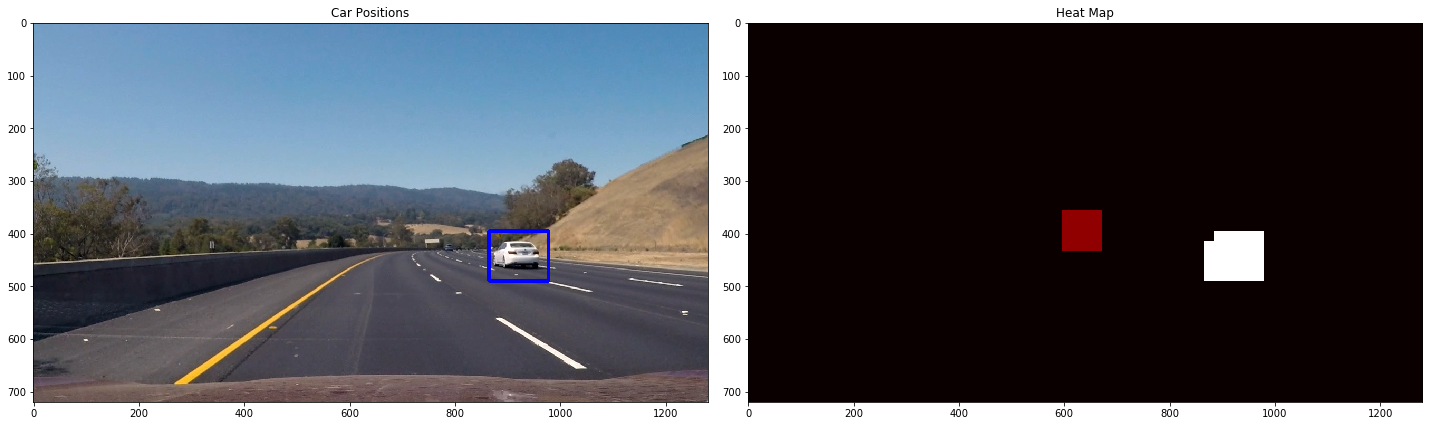

In [177]:
from scipy.ndimage.measurements import label
ystart = 300
ystop =  700
scale = 1.2
    
image = mpimg.imread('test_images/test3.jpg')

out_img, box_list = find_cars(image, color_space, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
plt.imshow(out_img)
plt.show()

# Read in image similar to one shown above 
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 0)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)
if heatmap is None:
    print("heatmap is none")


labels = label(heatmap)
#heatmap = extend_heatmap(labels, heatmap)
bboxes = Bboxes() 
draw_img = draw_labeled_bboxes(np.copy(image), labels, heatmap, 2.0)

fig = plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.show()


## Pipeline for video

In [178]:
def process_video(img):
    color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    ystart = 300
    ystop =  700
    scale = 1.2
    
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16)
    hist_feat = False
    spatial_feat = True
    hist_bins = 16    
    
    _, box_list = find_cars(img, color_space, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, box_list)
    #heat = apply_threshold(heat, 0)
    heatmap = np.clip(heat, 0, 255)
    if heatmap is None:
        print("heatmap is none")
        
    labels = label(heatmap)
    heatmap = extend_heatmap(labels, heatmap)
    labels = label(heatmap)
    bboxes = Bboxes() 
    
    if heatmap is None:
        print("heatmap is none")
        
    draw_img = draw_labeled_bboxes(np.copy(img), labels, heatmap, 3.0)
    return draw_img

In [181]:
from moviepy.editor import VideoFileClip
class Bboxes:
    frame_count = 0
    bbox_list = []
    curr_cord_list = []
    next_idx = 0
    
    def __init__(self):
        frame_count = 0
        bbox_list = []
        curr_cord_list = []
        next_idx = 0
        
bboxes = Bboxes() 
output = 'output_video.mp4'
clip_in = VideoFileClip("./project_video.mp4")
#clip_in = clip_in.subclip(29.0,34.0)
clip_out = clip_in.fl_image(process_video)
%time clip_out.write_videofile(output, audio=False, verbose=False)

100%|█████████▉| 1260/1261 [1:32:42<00:00,  1.00it/s]     


CPU times: user 20min 55s, sys: 26.5 s, total: 21min 21s
Wall time: 1h 32min 43s
